<a href="https://colab.research.google.com/github/Himank-J/ERAV2/blob/main/S9/ERAV2_S9_Himank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import albumentations
from albumentations import HorizontalFlip, ShiftScaleRotate, CoarseDropout
from albumentations.pytorch import ToTensorV2

In [26]:
train_transforms = albumentations.Compose(
    [
        HorizontalFlip(),
        ShiftScaleRotate(),
        CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=(0.49139968,0.48215841,0.44653091), mask_fill_value = None),
        albumentations.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784)),
        ToTensorV2(),
    ]
)

test_transforms = albumentations.Compose(
    [
        albumentations.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784)),
        ToTensorV2(),
    ]
)

In [27]:
class Cifar10SearchDataset(datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [28]:
train = Cifar10SearchDataset('./data', train=True, download=True, transform=train_transforms)
test = Cifar10SearchDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([128, 3, 32, 32])
labels.shape: torch.Size([128])


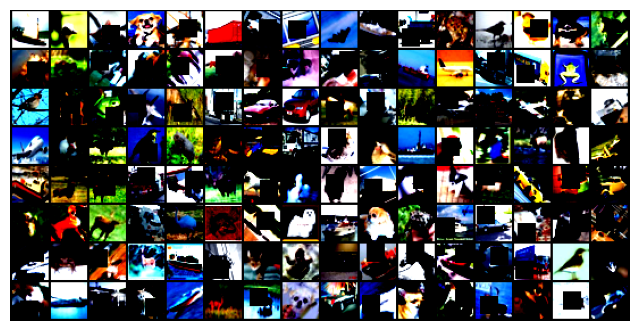

In [30]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, labels in train_loader:
  print('images.shape:', images.shape)
  print('labels.shape:', labels.shape)

  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0).clamp(0,1))
  break

In [35]:
dropout_value = 0.1

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# C1 C2 C3 C4 O
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

       # C1 Layer 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )

        # C1 Layer 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        # C1 Layer 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        )

        # C1 Layer 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(2, 2), padding=0, stride=2, bias=False),
        )

        # C2 Layer 1
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        # C2 Layer 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # C2 Layer 3
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        )

        # C2 Layer 4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(2, 2), padding=0, stride=2, bias=False),
        )

        # C3 Layer 1
        self.convblock9 = nn.Sequential(
            # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            #DepthwiseSeparableConv(in_channels=32, out_channels=64, kernel_size=3, padding=0, bias=False),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32, bias=False),
            nn.Conv2d(32, 64, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # C3 Layer 2
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, dilation=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # C3 Layer 3
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        )

        # C3 Layer 4
        self.convblock12 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(2, 2), padding=0, stride=2, bias=False),
        )

        # C4 Layer 1
        self.convblock13 = nn.Sequential(
            # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32, bias=False),
            nn.Conv2d(32, 64, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # C4 Layer 2
        self.convblock14 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # C4 Layer 3
        self.convblock15 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        )

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )

        self.convblock16 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        # x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        # x = self.pool1(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.convblock12(x)
        x = self.convblock13(x)
        x = self.convblock14(x)
        x = self.convblock15(x)
        x = self.gap(x)
        x = self.convblock16(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [36]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
           Conv2d-10           [-1, 16, 16, 16]           1,024
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1, 32,

In [37]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []
misclassified_pred_labels = []
misclassified_true_labels = []

def train(model, device, train_loader, optimizer, epoch):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            try:
              misclassified_indices = ~pred.eq(target.view_as(pred)).squeeze()
              misclassified_pred_labels.extend(pred[misclassified_indices].squeeze().tolist())
              misclassified_true_labels.extend(target[misclassified_indices].tolist())
              misclassified_images.extend(data[misclassified_indices])
            except Exception as e:
              pass

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [39]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.4433711767196655 Batch_id=390 Accuracy=34.63: 100%|██████████| 391/391 [00:13<00:00, 28.03it/s]



Test set: Average loss: 1.4410, Accuracy: 4807/10000 (48.07%)

EPOCH: 1


Loss=1.428545355796814 Batch_id=390 Accuracy=44.46: 100%|██████████| 391/391 [00:13<00:00, 28.28it/s]



Test set: Average loss: 1.3227, Accuracy: 5242/10000 (52.42%)

EPOCH: 2


Loss=1.5691454410552979 Batch_id=390 Accuracy=48.92: 100%|██████████| 391/391 [00:13<00:00, 28.54it/s]



Test set: Average loss: 1.1723, Accuracy: 5746/10000 (57.46%)

EPOCH: 3


Loss=1.2891147136688232 Batch_id=390 Accuracy=51.79: 100%|██████████| 391/391 [00:13<00:00, 28.85it/s]



Test set: Average loss: 1.0990, Accuracy: 6041/10000 (60.41%)

EPOCH: 4


Loss=1.5275776386260986 Batch_id=390 Accuracy=54.17: 100%|██████████| 391/391 [00:14<00:00, 27.28it/s]



Test set: Average loss: 1.0666, Accuracy: 6201/10000 (62.01%)

EPOCH: 5


Loss=1.0259907245635986 Batch_id=390 Accuracy=56.26: 100%|██████████| 391/391 [00:15<00:00, 26.03it/s]



Test set: Average loss: 0.9352, Accuracy: 6691/10000 (66.91%)

EPOCH: 6


Loss=1.0385314226150513 Batch_id=390 Accuracy=58.16: 100%|██████████| 391/391 [00:13<00:00, 28.41it/s]



Test set: Average loss: 0.9254, Accuracy: 6726/10000 (67.26%)

EPOCH: 7


Loss=0.878487765789032 Batch_id=390 Accuracy=59.46: 100%|██████████| 391/391 [00:13<00:00, 28.44it/s]



Test set: Average loss: 0.8572, Accuracy: 6935/10000 (69.35%)

EPOCH: 8


Loss=1.0630074739456177 Batch_id=390 Accuracy=60.49: 100%|██████████| 391/391 [00:13<00:00, 27.97it/s]



Test set: Average loss: 0.8334, Accuracy: 7083/10000 (70.83%)

EPOCH: 9


Loss=1.1129802465438843 Batch_id=390 Accuracy=61.78: 100%|██████████| 391/391 [00:14<00:00, 27.90it/s]



Test set: Average loss: 0.8313, Accuracy: 7080/10000 (70.80%)

EPOCH: 10


Loss=1.0143741369247437 Batch_id=390 Accuracy=62.44: 100%|██████████| 391/391 [00:13<00:00, 28.25it/s]



Test set: Average loss: 0.8061, Accuracy: 7171/10000 (71.71%)

EPOCH: 11


Loss=0.7597622275352478 Batch_id=390 Accuracy=63.13: 100%|██████████| 391/391 [00:13<00:00, 28.05it/s]



Test set: Average loss: 0.7836, Accuracy: 7260/10000 (72.60%)

EPOCH: 12


Loss=1.1528551578521729 Batch_id=390 Accuracy=63.85: 100%|██████████| 391/391 [00:13<00:00, 27.93it/s]



Test set: Average loss: 0.7696, Accuracy: 7290/10000 (72.90%)

EPOCH: 13


Loss=0.9264477491378784 Batch_id=390 Accuracy=64.66: 100%|██████████| 391/391 [00:13<00:00, 28.22it/s]



Test set: Average loss: 0.7332, Accuracy: 7439/10000 (74.39%)

EPOCH: 14


Loss=1.0205332040786743 Batch_id=390 Accuracy=64.82: 100%|██████████| 391/391 [00:13<00:00, 27.99it/s]



Test set: Average loss: 0.7318, Accuracy: 7443/10000 (74.43%)

EPOCH: 15


Loss=1.0872795581817627 Batch_id=390 Accuracy=65.63: 100%|██████████| 391/391 [00:13<00:00, 27.94it/s]



Test set: Average loss: 0.7090, Accuracy: 7553/10000 (75.53%)

EPOCH: 16


Loss=1.0743093490600586 Batch_id=390 Accuracy=66.11: 100%|██████████| 391/391 [00:14<00:00, 27.19it/s]



Test set: Average loss: 0.6989, Accuracy: 7547/10000 (75.47%)

EPOCH: 17


Loss=1.0028021335601807 Batch_id=390 Accuracy=66.37: 100%|██████████| 391/391 [00:14<00:00, 27.86it/s]



Test set: Average loss: 0.6921, Accuracy: 7583/10000 (75.83%)

EPOCH: 18


Loss=1.1422182321548462 Batch_id=390 Accuracy=66.84: 100%|██████████| 391/391 [00:14<00:00, 27.42it/s]



Test set: Average loss: 0.6960, Accuracy: 7555/10000 (75.55%)

EPOCH: 19


Loss=0.9153407216072083 Batch_id=390 Accuracy=67.22: 100%|██████████| 391/391 [00:14<00:00, 26.97it/s]



Test set: Average loss: 0.6711, Accuracy: 7670/10000 (76.70%)

EPOCH: 20


Loss=0.7885675430297852 Batch_id=390 Accuracy=67.79: 100%|██████████| 391/391 [00:14<00:00, 26.68it/s]



Test set: Average loss: 0.6778, Accuracy: 7610/10000 (76.10%)

EPOCH: 21


Loss=0.8744487762451172 Batch_id=390 Accuracy=68.11: 100%|██████████| 391/391 [00:14<00:00, 27.63it/s]



Test set: Average loss: 0.6434, Accuracy: 7747/10000 (77.47%)

EPOCH: 22


Loss=0.7112296223640442 Batch_id=390 Accuracy=68.04: 100%|██████████| 391/391 [00:14<00:00, 27.70it/s]



Test set: Average loss: 0.6607, Accuracy: 7730/10000 (77.30%)

EPOCH: 23


Loss=0.8036901354789734 Batch_id=390 Accuracy=68.18: 100%|██████████| 391/391 [00:13<00:00, 27.94it/s]



Test set: Average loss: 0.6630, Accuracy: 7682/10000 (76.82%)

EPOCH: 24


Loss=0.9327403903007507 Batch_id=390 Accuracy=69.03: 100%|██████████| 391/391 [00:14<00:00, 26.98it/s]



Test set: Average loss: 0.6380, Accuracy: 7749/10000 (77.49%)

EPOCH: 25


Loss=1.0883268117904663 Batch_id=390 Accuracy=69.19: 100%|██████████| 391/391 [00:14<00:00, 27.57it/s]



Test set: Average loss: 0.6064, Accuracy: 7881/10000 (78.81%)

EPOCH: 26


Loss=0.9692762494087219 Batch_id=390 Accuracy=69.57: 100%|██████████| 391/391 [00:14<00:00, 27.52it/s]



Test set: Average loss: 0.6321, Accuracy: 7809/10000 (78.09%)

EPOCH: 27


Loss=0.6677980422973633 Batch_id=390 Accuracy=69.63: 100%|██████████| 391/391 [00:13<00:00, 27.94it/s]



Test set: Average loss: 0.6223, Accuracy: 7821/10000 (78.21%)

EPOCH: 28


Loss=0.8286941647529602 Batch_id=390 Accuracy=70.14: 100%|██████████| 391/391 [00:14<00:00, 27.44it/s]



Test set: Average loss: 0.6136, Accuracy: 7869/10000 (78.69%)

EPOCH: 29


Loss=1.0162997245788574 Batch_id=390 Accuracy=69.93: 100%|██████████| 391/391 [00:14<00:00, 27.72it/s]



Test set: Average loss: 0.5947, Accuracy: 7940/10000 (79.40%)

EPOCH: 30


Loss=0.8739544749259949 Batch_id=390 Accuracy=70.31: 100%|██████████| 391/391 [00:13<00:00, 28.01it/s]



Test set: Average loss: 0.6110, Accuracy: 7853/10000 (78.53%)

EPOCH: 31


Loss=0.8715679049491882 Batch_id=390 Accuracy=70.38: 100%|██████████| 391/391 [00:14<00:00, 27.38it/s]



Test set: Average loss: 0.5826, Accuracy: 7958/10000 (79.58%)

EPOCH: 32


Loss=0.7074301838874817 Batch_id=390 Accuracy=70.65: 100%|██████████| 391/391 [00:13<00:00, 28.07it/s]



Test set: Average loss: 0.5898, Accuracy: 7948/10000 (79.48%)

EPOCH: 33


Loss=0.8209799528121948 Batch_id=390 Accuracy=70.87: 100%|██████████| 391/391 [00:14<00:00, 27.37it/s]



Test set: Average loss: 0.5861, Accuracy: 7978/10000 (79.78%)

EPOCH: 34


Loss=0.8830603361129761 Batch_id=390 Accuracy=70.84: 100%|██████████| 391/391 [00:14<00:00, 26.80it/s]



Test set: Average loss: 0.5745, Accuracy: 7994/10000 (79.94%)

EPOCH: 35


Loss=0.6935254335403442 Batch_id=390 Accuracy=71.12: 100%|██████████| 391/391 [00:14<00:00, 26.79it/s]



Test set: Average loss: 0.6090, Accuracy: 7861/10000 (78.61%)

EPOCH: 36


Loss=0.5581797957420349 Batch_id=390 Accuracy=71.38: 100%|██████████| 391/391 [00:14<00:00, 26.88it/s]



Test set: Average loss: 0.5837, Accuracy: 7967/10000 (79.67%)

EPOCH: 37


Loss=0.8878816366195679 Batch_id=390 Accuracy=71.39: 100%|██████████| 391/391 [00:14<00:00, 26.90it/s]



Test set: Average loss: 0.5673, Accuracy: 8029/10000 (80.29%)

EPOCH: 38


Loss=0.9221236109733582 Batch_id=390 Accuracy=71.62: 100%|██████████| 391/391 [00:16<00:00, 24.25it/s]



Test set: Average loss: 0.5720, Accuracy: 8015/10000 (80.15%)

EPOCH: 39


Loss=0.8614748120307922 Batch_id=390 Accuracy=71.64: 100%|██████████| 391/391 [00:15<00:00, 25.82it/s]



Test set: Average loss: 0.5572, Accuracy: 8047/10000 (80.47%)

